In [94]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings
import pyfolio as pf
warnings.simplefilter('ignore')

# Momentum-Based Asset Allocation Strategy

This momentum-based asset allocation strategy trades once per month and utilizes three asset groups: the investment universe, crash protection, and canary assets. The methodology combines momentum scoring, covariance-based weighting, and conditional investment based on the performance of canary assets.

### 1. Asset Groups

- **Investment Universe:** $ A_{inv} = \{SPY, VGK, EWJ, EEM, VNQ, RWX, IEF, TLT, DBC, GLD\}$
- **Crash Protection:** $A_{cp} = \{IEF, Cash\}$
- **Canary Assets:** $A_{can} = \{EEM, AGG\}$

### 2. Momentum Score Calculation

On the last trading day of the month, calculate the momentum score for each asset in the investment universe.

#### Formula for Momentum Score:

$
\text{Momentum Score} = \left(12 \times \frac{p_0}{p_1}\right) + \left(4 \times \frac{p_0}{p_3}\right) + \left(2 \times \frac{p_0}{p_6}\right) + \frac{p_0}{p_{12}} - 19
$

where:
- $p_0$ is today's price
- $p_1$ is the price at the close of last month
- $p_3$ is the price at the close of three months ago
- $p_6$ is the price at the close of six months ago
- $p_{12}$ is the price at the close of twelve months ago

### 3. Selection of Top Assets

Select the top 5 (or fewer) assets from the investment universe that have a positive momentum score.

### 4. Asset Weighting Using Covariance Matrix

Calculate the asset weighting using a covariance matrix with 1-month volatility estimates and weighted correlations.

#### Weighting Formula:

$
\text{Weighting} = \frac{(12 \times \text{1-month correlation}) + (4 \times \text{3-month correlation}) + (2 \times \text{6-month correlation}) + \text{12-month correlation}}{19}
$

### 5. Percentage Invested Using Canary Assets

Determine the percentage of the portfolio invested in the investment universe based on the momentum scores of the canary assets.

#### Investment Rules:

- If both canary assets have a positive momentum score, invest 100% in the top 5 (or fewer) investment universe assets.
- If one canary asset has a positive momentum score, invest 50% in crash protection and 50% in the investment universe.
- If neither canary asset has a positive momentum score, invest 100% in crash protection.

### 6. Crash Protection Allocation

If crash protection is used, allocate the funds to IEF if it has a positive momentum score. Otherwise, allocate to cash.

### Summary

The momentum-based asset allocation strategy dynamically adjusts the portfolio by:
1. Calculating a momentum score for each asset in the investment universe.
2. Selecting the top assets with positive momentum scores.
3. Calculating asset weights using a covariance matrix and volatility estimates.
4. Determining the percentage allocation to the investment universe based on the momentum scores of canary assets.
5. Applying crash protection if needed, by allocating to IEF or cash based on their momentum scores.

By integrating momentum scoring, covariance-based weighting, and conditional investment rules, this strategy aims to achieve a diversified and risk-managed portfolio that adapts to changing market conditions.


[*********************100%%**********************]  12 of 12 completed
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


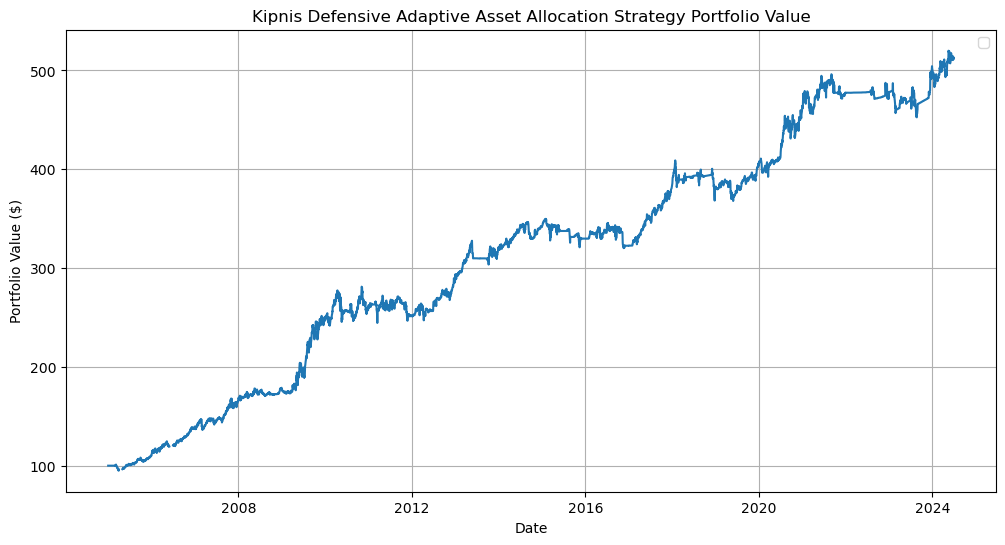

In [96]:
investment_universe = ['SPY', 'VGK', 'EWJ', 'EEM', 'VNQ', 'RWX', 'IEF', 'TLT', 'DBC', 'GLD']
crash_protection_assets = ['IEF', 'BIL']
canary_assets = ['EEM', 'AGG']
assets = investment_universe + crash_protection_assets + canary_assets

# Download data
data = yf.download(assets, start="2004-01-01")['Adj Close']
monthly_prices = data.resample('BM').last()
returns = monthly_prices.pct_change()

# Function to calculate momentum score
def calculate_momentum_score(prices):
    p0 = prices.iloc[-1]
    p1 = prices.iloc[-2]
    p3 = prices.iloc[-4]
    p6 = prices.iloc[-7]
    p12 = prices.iloc[-13]
    momentum_score = (12 * (p0 / p1) + 4 * (p0 / p3) + 2 * (p0 / p6) + (p0 / p12)) - 19
    return momentum_score

# Initialize the allocations DataFrame
allocations = pd.DataFrame(index=returns.index, columns=investment_universe + crash_protection_assets).fillna(0)

# Perform monthly rebalancing
for date in returns.index[13:]:
    momentum_scores_risk = monthly_prices[investment_universe].loc[:date].apply(calculate_momentum_score, axis=0)
    momentum_scores_canary = monthly_prices[canary_assets].loc[:date].apply(calculate_momentum_score, axis=0)
    
    # Check canary momentum scores
    if (momentum_scores_canary <= 0).all():
        if momentum_scores_canary['EEM'] > 0:
            allocations.loc[date, 'IEF'] = 1.0
        else:
            allocations.loc[date, 'BIL'] = 1.0
    elif (momentum_scores_canary > 0).all():
        top_assets = momentum_scores_risk[momentum_scores_risk > 0].nlargest(5).index
        allocations.loc[date, top_assets] = 1 / len(top_assets)
    else:
        if momentum_scores_canary['EEM'] > 0:
            allocations.loc[date, 'IEF'] = 0.5
        else:
            allocations.loc[date, 'BIL'] = 0.5
        top_assets = momentum_scores_risk[momentum_scores_risk > 0].nlargest(5).index
        allocations.loc[date, top_assets] = 0.1
        
# Forward fill allocations to daily frequency
daily_allocation_df = allocations.reindex(data.index, method='ffill')

# Calculate daily returns of the strategy
strategy_daily_returns = pd.Series(0, index=data.index)
for date, allocation in daily_allocation_df.iterrows():
    daily_returns = sum(data[asset].pct_change().loc[date] * weight for asset, weight in allocation.items() if weight > 0)
    strategy_daily_returns.loc[date] = daily_returns

# Define initial investment
initial_investment = 100

# Calculate the cumulative returns of the strategy
strategy_cumulative_returns = (1 + strategy_daily_returns).cumprod()

# Calculate the portfolio value over time
portfolio_value = strategy_cumulative_returns * initial_investment

# Plot the portfolio value over time
plt.figure(figsize=(12, 6))
plt.plot(portfolio_value[251:])
plt.title('Kipnis Defensive Adaptive Asset Allocation Strategy Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()


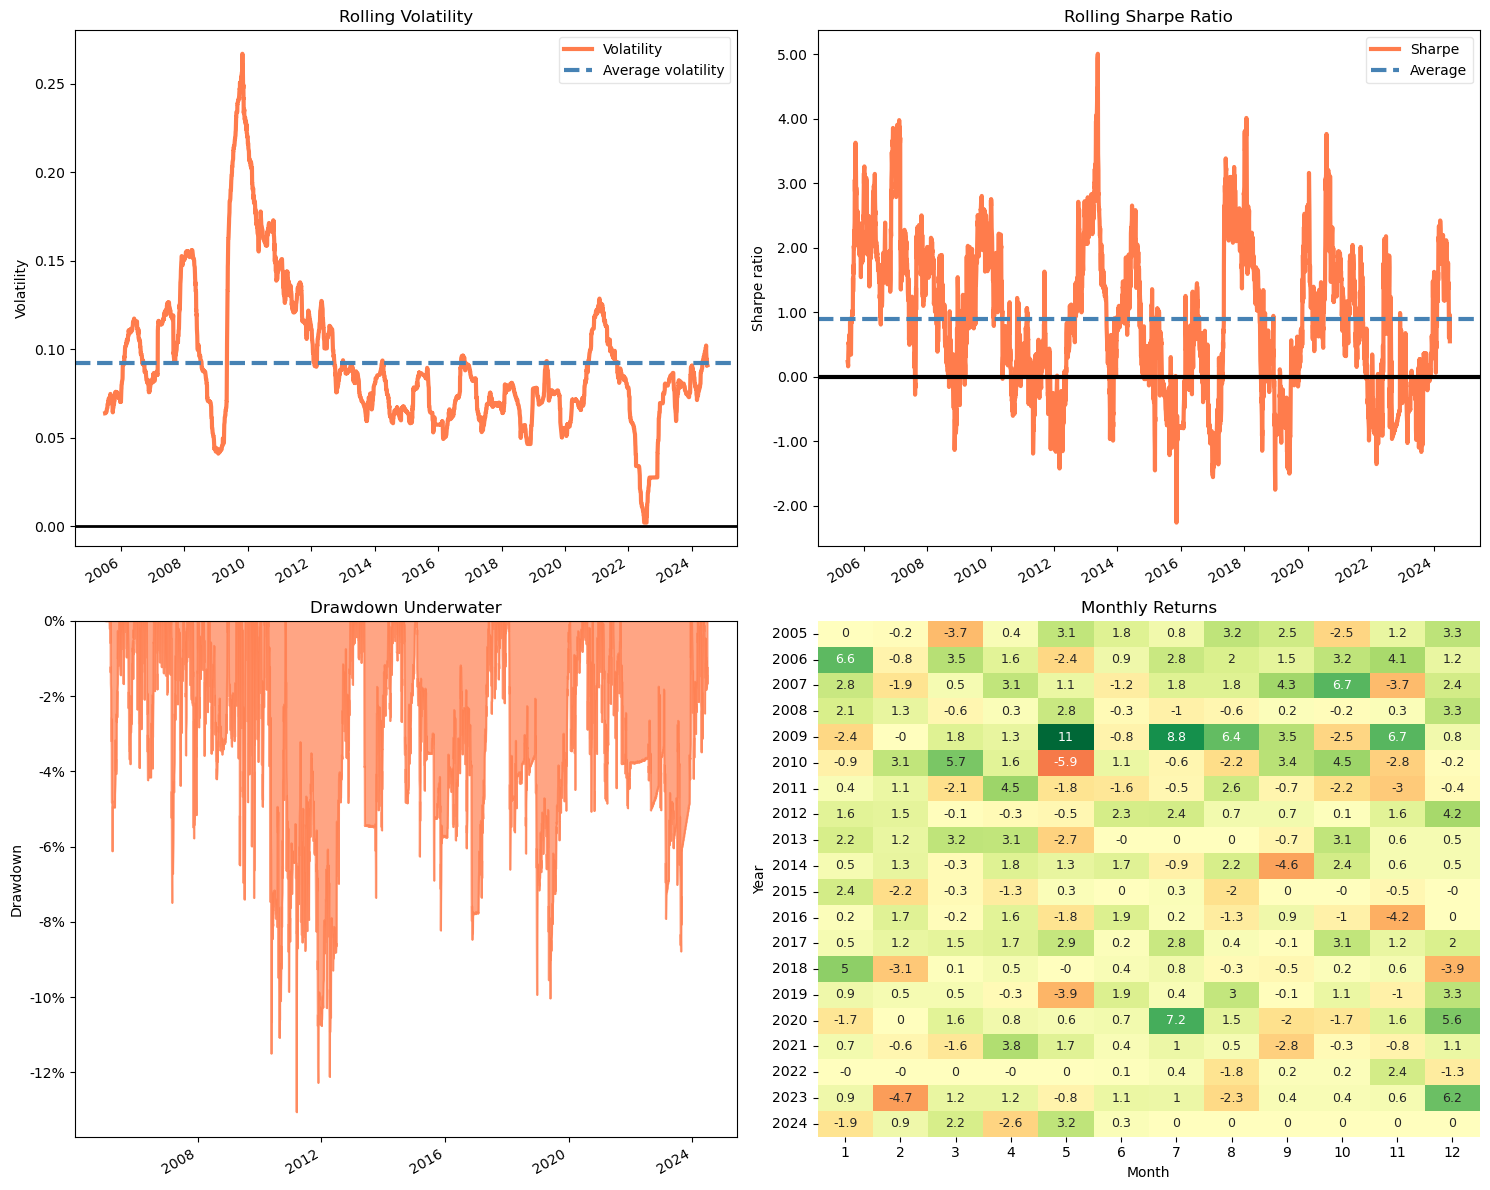

Annual return          0.087584
Cumulative returns     4.123594
Annual volatility      0.100203
Sharpe ratio           0.888140
Calmar ratio           0.670646
Stability              0.899657
Max drawdown          -0.130596
Omega ratio            1.195711
Sortino ratio          1.274634
Skew                  -0.159678
Kurtosis               7.190385
Tail ratio             0.994770
Daily value at risk   -0.012271
dtype: float64


In [97]:
strategy_returns = portfolio_value[251:].pct_change().dropna()
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

plt.sca(axs[0, 0])
pf.plot_rolling_volatility(strategy_returns, ax=axs[0, 0])
axs[0, 0].set_title('Rolling Volatility')

plt.sca(axs[0, 1])
pf.plot_rolling_sharpe(strategy_returns, ax=axs[0, 1])
axs[0, 1].set_title('Rolling Sharpe Ratio')

plt.sca(axs[1, 0])
pf.plot_drawdown_underwater(strategy_returns, ax=axs[1, 0])
axs[1, 0].set_title('Drawdown Underwater')

plt.sca(axs[1, 1])
pf.plot_monthly_returns_heatmap(strategy_returns)
axs[1, 1].set_title('Monthly Returns')

plt.tight_layout()
plt.show()


perf_stats = pf.timeseries.perf_stats(strategy_returns)
print(perf_stats)

<AxesSubplot:title={'center':'Annual returns'}, xlabel='Returns', ylabel='Year'>

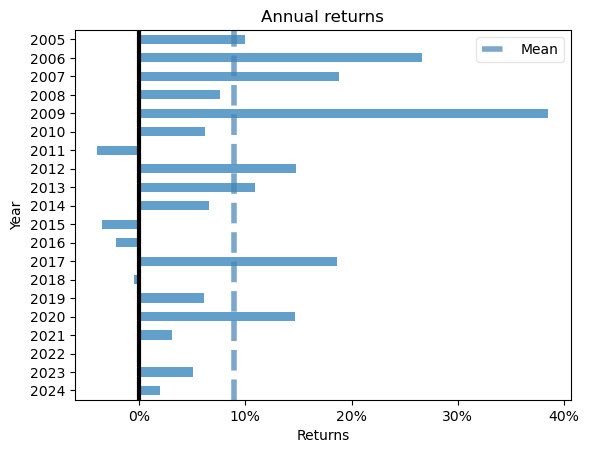

In [99]:
pf.plot_annual_returns(strategy_returns)